---
format:
  html:
   code-fold: true
   code-summary: "Show the code"
   toc: true
   page-layout: full
jupyter: Python3

---

# 2 - Where to spend leisure time in NYC?

This project aims to explore the spatial distribution of some leisure spaces in New York City, including indoor spaces like museums, art galleries, and theatres, and outddoor spaces like parks or open streets. The project first aims to idenfity some patterns of spatial distribution of such spaces in each borough and neighborhood, and in relation to population and median household income. Then some interactive visualization is created for both local NYC residents and tourists to access to information about some leisure spaces more easily. 

## Imports

In [1]:
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import math

%matplotlib inline

## NYC Base Maps

### Tracts, Neighborhood, and Borough

nyc_tracts = pd.read_csv("data/2022 Census Tracts.csv")
nyc_tracts['geometry'] = gpd.GeoSeries.from_wkt(nyc_tracts['the_geom'])
geo_tracts = gpd.GeoDataFrame(nyc_tracts, geometry='geometry')
geo_tracts = geo_tracts.set_crs(epsg=4326)
tracts = geo_tracts[['BoroName', 'CT2020', 'BoroCT2020', 'NTAName', 'Shape_Area','geometry','GEOID']].copy()
tracts_clean = tracts[['BoroName', 'CT2020', 'NTAName', 'geometry','GEOID']]
Boro_NTA = tracts_clean[['BoroName', 'NTAName']].drop_duplicates(subset = "NTAName")

## Dataset Selection & Setup


After glancing through NYC Open Data portal, I have selected art galleries, museums, libraries, theatres, and parks as common leisure spaces. In addition, I explored data of open streets, a program thatt had been implemented in many global cities including New York City to transform roads into public spaces for cultural and all kinds of events on particular days (mostly on weekends). 

This step is to bring in all datasets, clean them up, and aggregate different types of leisure spaces. The aggregated dataframe is then spacially joined with tracts, neighborhood, and boroughs, ready for further investigation on their geospatial distributions. 

Similar data wrangling is performed on parks. Since parks come in polygon instead of points, which may result in problems with spatial joins, in the case when one park falls in two or more tracts or neighborhood. Hence, the geometry of parks' centroids is adopted to replace the polygon geometry for further analysis.

The Open Street data comes with more detailed information on the approved time for each street. The days of week (e.g. Monday) and time of the day (e.g. 7:30) that it opens and closes are rearranged by melting and pivoting. 

Additionally, 2020 Census Data on population and median household income are brought in for analysis.

### Indoor Leisure Spaces: Art Galleries, Museums, Libraries, and Theatres

In [3]:
# establish geodataframe
art_galleries = gpd.read_file("data/art galleries.geojson")
geo_art_galleries = gpd.GeoDataFrame(art_galleries, geometry='geometry')
geo_art_galleries = art_galleries.set_crs(epsg=4326)

# add type
art_galleries_clean = geo_art_galleries[['name','zip','address1','geometry']]
art_galleries_clean.loc[:,"Type"]= "Art Galleries"
art_galleries_clean.rename(
    columns={"address1": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)

/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/1429971093.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  art_galleries_clean.rename(


In [4]:
# Museums 

# establish geodataframe
museums = gpd.read_file("data/museums.geojson")
geo_museums= gpd.GeoDataFrame(museums, geometry='geometry')
geo_museums = geo_museums.set_crs(epsg=4326)
geo_museums

# add type
museums_clean = geo_museums[['name','zip','adress1','geometry']]
museums_clean.loc[:,"Type"]= "Museums"
museums_clean.rename(
    columns={"adress1": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)
museums_clean


/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/3071166290.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  museums_clean.rename(


Name      Zip  \
0              Alexander Hamilton U.S. Custom House  10004.0   
1                         Alice Austen House Museum  10305.0   
2              American Academy of Arts and Letters  10032.0   
3                          American Folk Art Museum  10019.0   
4               American Immigration History Center      0.0   
..                                              ...      ...   
125  American Sephardi Federation / Sephardic House  10011.0   
126              YIVO Institute for Jewish Research  10011.0   
127              American Jewish Historical Society  10011.0   
128                       Yeshiva University Museum  10011.0   
129                       Center For Jewish History  10011.0   

                 Address                    geometry     Type  
0          1 Bowling Grn  POINT (-74.01376 40.70382)  Museums  
1           2 Hylan Blvd  POINT (-74.06303 40.61512)  Museums  
2       633 W. 155th St.  POINT (-73.94730 40.83385)  Museums  
3    45 West 53rd Street  POINT (-73.97810 40.76162)  Museums  
4           Ellis Island  POINT (-74.03968 40.69906)  Museums  
..                   ...                         ...      ...  
125       15 W. 16th St.  POINT (-73.99389 40.73808)  Museums  
126       15 W. 16th St.  POINT (-73.99379 40.73796)  Museums  
127       15 W. 16th St.  POINT (-73.99393 40.73802)  Museums  
128       15 W. 16th St.  POINT (-73.99382 40.73805)  Museums  
129       15 W. 16th St.  POINT (-73.99387 40.73799)  Museums  

[130 rows x 5 columns]

In [5]:
# Libraries

# establish geodataframe
library = gpd.read_file("data/libraries.geojson")
geo_library = gpd.GeoDataFrame(library, geometry='geometry')
geo_library= geo_library.set_crs(epsg=4326)
geo_library

# add type
library_clean = geo_library[['name','zip','streetname','geometry']]
library_clean.loc[:,"Type"]= "Libraries"
library_clean.rename(
    columns={"streetname": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)
library_clean


/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/3524914390.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  library_clean.rename(


Name    Zip            Address                    geometry  \
0    115th Street  10026  West 115th Street  POINT (-73.95353 40.80298)   
1    125th Street  10035  East 125th Street  POINT (-73.93485 40.80302)   
2     53rd Street  10019   West 53rd Street  POINT (-73.97736 40.76081)   
3     58th Street  10022   East 58th Street  POINT (-73.96938 40.76219)   
4     67th Street  10065   East 67th Street  POINT (-73.95955 40.76492)   
..            ...    ...                ...                         ...   
211     Sunnyside  11104  Greenpoint Avenue  POINT (-73.92167 40.74085)   
212    Whitestone  11357            14 Road  POINT (-73.81070 40.78854)   
213  Windsor Park  11364     Bell Boulevard  POINT (-73.75562 40.73450)   
214     Woodhaven  11421     Forest Parkway  POINT (-73.86146 40.69453)   
215      Woodside  11377    Skillman Avenue  POINT (-73.90979 40.74534)   

          Type  
0    Libraries  
1    Libraries  
2    Libraries  
3    Libraries  
4    Libraries  
..         ...  
211  Libraries  
212  Libraries  
213  Libraries  
214  Libraries  
215  Libraries  

[216 rows x 5 columns]

In [6]:
# Theaters
# establish geodataframe
theaters = gpd.read_file("data/Theaters.geojson")
geo_theaters = gpd.GeoDataFrame(theaters, geometry='geometry')
geo_theaters= geo_theaters.set_crs(epsg=4326)
geo_theaters


# add type
theaters_clean = geo_theaters[['name','zip','address1','geometry']]
theaters_clean.loc[:,"Type"]= "Theatres"
theaters_clean.rename(
    columns={"address1": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)
theaters_clean


/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/1518346627.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theaters_clean.rename(


Name      Zip                                 Address  \
0      45th Street Theater  10036.0                    354 West 45th Street   
1      47th Street Theater  10036.0                    304 West 47th Street   
2                    59E59  10022.0                     59 East 59th Street   
3            Acorn Theater  10036.0                    410 West 42nd Street   
4    Al Hirschfeld Theater  10036.0                       302 W 45th Street   
..                     ...      ...                                     ...   
112       Westside Theater  10036.0                           407 W 43rd St   
113          Wings Theatre  10014.0                      154 Christopher St   
114  Winter Garden Theatre  10019.0                           1634 Broadway   
115           York Theatre  10022.0                       619 Lexington Ave   
116      Delacorte Theater      0.0  Central Park - Mid-Park at 80th Street   

                       geometry      Type  
0    POINT (-73.99062 40.75985)  Theatres  
1    POINT (-73.98811 40.76047)  Theatres  
2    POINT (-73.97038 40.76340)  Theatres  
3    POINT (-73.99332 40.75854)  Theatres  
4    POINT (-73.98921 40.75926)  Theatres  
..                          ...       ...  
112  POINT (-73.99255 40.75953)  Theatres  
113  POINT (-74.00889 40.73240)  Theatres  
114  POINT (-73.98348 40.76152)  Theatres  
115  POINT (-73.96998 40.75836)  Theatres  
116  POINT (-73.96882 40.78018)  Theatres  

[117 rows x 5 columns]

#### Aggregate all types of indoor leisure space

In [7]:
frames = [art_galleries_clean, museums_clean, library_clean, theaters_clean]

total_indoor = pd.concat(frames)

total_indoor

Name      Zip  \
0                            O'reilly William & Co Ltd  10021.0   
1    Organization of Independent Artists - Gallery 402  10013.0   
2                                         Owen Gallery  10021.0   
3                                     P P O W Gallerie  10001.0   
4                                          P P O W Inc  10013.0   
..                                                 ...      ...   
112                                   Westside Theater  10036.0   
113                                      Wings Theatre  10014.0   
114                              Winter Garden Theatre  10019.0   
115                                       York Theatre  10022.0   
116                                  Delacorte Theater      0.0   

                                    Address                    geometry  \
0                              52 E 76th St  POINT (-73.96273 40.77380)   
1                             19 Hudson St.  POINT (-74.00939 40.71647)   
2                              19 E 75th St  POINT (-73.96435 40.77400)   
3                             511 W 25th St  POINT (-74.00389 40.74959)   
4                             476 Broome St  POINT (-74.00176 40.72291)   
..                                      ...                         ...   
112                           407 W 43rd St  POINT (-73.99255 40.75953)   
113                      154 Christopher St  POINT (-74.00889 40.73240)   
114                           1634 Broadway  POINT (-73.98348 40.76152)   
115                       619 Lexington Ave  POINT (-73.96998 40.75836)   
116  Central Park - Mid-Park at 80th Street  POINT (-73.96882 40.78018)   

              Type  
0    Art Galleries  
1    Art Galleries  
2    Art Galleries  
3    Art Galleries  
4    Art Galleries  
..             ...  
112       Theatres  
113       Theatres  
114       Theatres  
115       Theatres  
116       Theatres  

[1380 rows x 5 columns]

#### Spatial Join

In [9]:
geo_total_indoor = gpd.sjoin(
    total_indoor,  # The point data for 311 tickets
    tracts_clean.to_crs(total_indoor.crs),  # The neighborhoods (in the same CRS)
    predicate="within",
    how="left",
)
geo_total_indoor.head()

Name      Zip        Address  \
0                          O'reilly William & Co Ltd  10021.0   52 E 76th St   
1  Organization of Independent Artists - Gallery 402  10013.0  19 Hudson St.   
2                                       Owen Gallery  10021.0   19 E 75th St   
3                                   P P O W Gallerie  10001.0  511 W 25th St   
4                                        P P O W Inc  10013.0  476 Broome St   

                     geometry           Type  index_right   BoroName   CT2020  \
0  POINT (-73.96273 40.77380)  Art Galleries         84.0  Manhattan  13000.0   
1  POINT (-74.00939 40.71647)  Art Galleries         17.0  Manhattan   3900.0   
2  POINT (-73.96435 40.77400)  Art Galleries         84.0  Manhattan  13000.0   
3  POINT (-74.00389 40.74959)  Art Galleries       1134.0  Manhattan   9901.0   
4  POINT (-74.00176 40.72291)  Art Galleries       1156.0  Manhattan   4900.0   

                           NTAName         GEOID  
0    Upper East Side-Carnegie Hill  3.606101e+10  
1             Tribeca-Civic Center  3.606100e+10  
2    Upper East Side-Carnegie Hill  3.606101e+10  
3             Chelsea-Hudson Yards  3.606101e+10  
4  SoHo-Little Italy-Hudson Square  3.606100e+10

### Outdoor Leisure Space: Parks

In [10]:
# Parks
# establish geodataframe
parks = gpd.read_file("data/Parks Properties.geojson")
geo_parks = gpd.GeoDataFrame(parks, geometry='geometry')
geo_parks= geo_parks.set_crs(epsg=4326)
geo_parks


# add type
parks_clean = geo_parks[['signname','geometry','acres']]
parks_clean.loc[:,"Type"]= "Parks"
parks_clean.rename(
    columns={"location": "Address", "signname": "Name", "zipcode": "Zip"},
    inplace=True,)

parks_clean['new_geom'] = parks_clean['geometry']


/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/1177565529.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parks_clean.rename(
/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [22]:

# Since many parks are in multi-polygons, which will lead to errors when doing spatial join later, a centroid of each park is generated here for smoother spatial join.
parks_clean['geometry'] = parks_clean['geometry'].centroid

geo_parks_clean = gpd.sjoin(
    parks_clean,  # The point data for 311 tickets
    tracts_clean.to_crs(parks_clean.crs),  # The neighborhoods (in the same CRS)
    predicate="within",
    how="left",
)
geo_parks_clean

/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/3082874007.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parks_clean['geometry'] = parks_clean['geometry'].centroid
/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Name                    geometry    acres  \
0                    Inwood Hill Park  POINT (-73.92544 40.87257)  196.398   
1                Challenge Playground  POINT (-73.72796 40.75662)    2.035   
2                    Sunset Cove Park  POINT (-73.82300 40.59853)    9.375   
3     Grand Central Parkway Extension  POINT (-73.85317 40.75316)  249.389   
4                       Idlewild Park  POINT (-73.75229 40.65043)   180.85   
...                               ...                         ...      ...   
2040             Maria Hernandez Park  POINT (-73.92386 40.70317)    6.873   
2041            Crotona Parkway Malls  POINT (-73.88477 40.84405)     8.75   
2042                             Park  POINT (-73.89807 40.84408)    0.511   
2043                  Cunningham Park  POINT (-73.76880 40.73382)    358.0   
2044       Roberto Clemente Ballfield  POINT (-73.96767 40.70635)     1.93   

       Type                                           new_geom  index_right  \
0     Parks  MULTIPOLYGON (((-73.92093 40.86999, -73.92145 ...       2191.0   
1     Parks  MULTIPOLYGON (((-73.72738 40.75605, -73.72783 ...        936.0   
2     Parks  MULTIPOLYGON (((-73.82218 40.59892, -73.82221 ...       1129.0   
3     Parks  MULTIPOLYGON (((-73.85875 40.76741, -73.85976 ...        625.0   
4     Parks  MULTIPOLYGON (((-73.75809 40.65427, -73.75845 ...       1013.0   
...     ...                                                ...          ...   
2040  Parks  MULTIPOLYGON (((-73.92251 40.70351, -73.92381 ...       1729.0   
2041  Parks  MULTIPOLYGON (((-73.88496 40.84470, -73.88496 ...        336.0   
2042  Parks  MULTIPOLYGON (((-73.89759 40.84410, -73.89773 ...       1229.0   
2043  Parks  MULTIPOLYGON (((-73.77466 40.72442, -73.77439 ...       2241.0   
2044  Parks  MULTIPOLYGON (((-73.96761 40.70581, -73.96735 ...       2220.0   

       BoroName    CT2020                                            NTAName  \
0     Manhattan   29700.0                                   Inwood Hill Park   
1        Queens  152902.0                             Douglaston-Little Neck   
2        Queens  107201.0  Breezy Point-Belle Harbor-Rockaway Park-Broad ...   
3        Queens   39902.0                                       North Corona   
4        Queens   66404.0             Springfield Gardens (South)-Brookville   
...         ...       ...                                                ...   
2040   Brooklyn   42900.0                                    Bushwick (West)   
2041      Bronx   36300.0                                         West Farms   
2042      Bronx   16500.0                 Claremont Village-Claremont (East)   
2043     Queens  128300.0                                    Cunningham Park   
2044   Brooklyn   54500.0                                 South Williamsburg   

             GEOID  
0     3.606103e+10  
1     3.608115e+10  
2     3.608111e+10  
3     3.608104e+10  
4     3.608107e+10  
...            ...  
2040  3.604704e+10  
2041  3.600504e+10  
2042  3.600502e+10  
2043  3.608113e+10  
2044  3.604705e+10  

[2045 rows x 10 columns]

### Outdoor Leisure Space: Open Streets

In [12]:
open_streets = gpd.read_file("data/Open Streets Locations.geojson")
geo_open_streets = gpd.GeoDataFrame(open_streets, geometry='geometry', crs=2263)
geo_open_streets = open_streets.to_crs(epsg=4326)

open_streets_clean = geo_open_streets[['appronstre','apprtostre','apprdayswe','boroughname','reviewstat','shape_stle','geometry']]

In [13]:
join_test = gpd.sjoin(
    open_streets_clean,  # The point data for 311 tickets
    tracts_clean.to_crs(open_streets_clean.crs),  # The neighborhoods (in the same CRS)
    predicate="within",
    how="left",
)
join_test.head()

appronstre      apprtostre           apprdayswe    boroughname  \
0  DEISIUS STREET  STECHER STREET  mon,tue,wed,thu,fri  Staten Island   
1  SUFFOLK AVENUE   HAROLD STREET          fri,sat,sun  Staten Island   
2  SUFFOLK AVENUE   HAROLD STREET          fri,sat,sun  Staten Island   
3   VERMONT COURT  SUFFOLK AVENUE          fri,sat,sun  Staten Island   
4        9 STREET     ROSE AVENUE          fri,sat,sun  Staten Island   

            reviewstat     shape_stle  \
0  approvedFullSchools  264.932398036   
1         approvedFull  313.087821487   
2         approvedFull  142.063500219   
3         approvedFull  421.392020366   
4         approvedFull  448.103939286   

                                            geometry  index_right  \
0  MULTILINESTRING ((-74.18738 40.53028, -74.1882...       1318.0   
1  MULTILINESTRING ((-74.12784 40.60288, -74.1277...       1323.0   
2  MULTILINESTRING ((-74.12772 40.60202, -74.1276...       1323.0   
3  MULTILINESTRING ((-74.12620 40.60209, -74.1277...       1323.0   
4  MULTILINESTRING ((-74.11481 40.57316, -74.1157...       1300.0   

        BoroName   CT2020                                            NTAName  \
0  Staten Island  17600.0             Annadale-Huguenot-Prince's Bay-Woodrow   
1  Staten Island  18703.0  Todt Hill-Emerson Hill-Lighthouse Hill-Manor H...   
2  Staten Island  18703.0  Todt Hill-Emerson Hill-Lighthouse Hill-Manor H...   
3  Staten Island  18703.0  Todt Hill-Emerson Hill-Lighthouse Hill-Manor H...   
4  Staten Island  13400.0                             New Dorp-Midland Beach   

          GEOID  
0  3.608502e+10  
1  3.608502e+10  
2  3.608502e+10  
3  3.608502e+10  
4  3.608501e+10

In [15]:
join_test['monday'] = join_test['apprdayswe'].str.count('mon')
join_test['tuesday'] = join_test['apprdayswe'].str.count('tue')
join_test['wednesday'] = join_test['apprdayswe'].str.count('wed')
join_test['thursday'] = join_test['apprdayswe'].str.count('thu')
join_test['friday'] = join_test['apprdayswe'].str.count('fri')
join_test['saturday'] = join_test['apprdayswe'].str.count('sat')
join_test['sunday'] = join_test['apprdayswe'].str.count('sun')
join_test['dayscount'] = join_test[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum(axis=1)

join_test

appronstre          apprtostre                   apprdayswe  \
0    DEISIUS STREET      STECHER STREET          mon,tue,wed,thu,fri   
1    SUFFOLK AVENUE       HAROLD STREET                  fri,sat,sun   
2    SUFFOLK AVENUE       HAROLD STREET                  fri,sat,sun   
3     VERMONT COURT      SUFFOLK AVENUE                  fri,sat,sun   
4          9 STREET         ROSE AVENUE                  fri,sat,sun   
..              ...                 ...                          ...   
361     BECK STREET      AVENUE ST JOHN                          wed   
362  NEWKIRK AVENUE      EAST 17 STREET                          sun   
363       18 STREET            4 AVENUE          mon,tue,wed,thu,fri   
364       34 AVENUE  JUNCTION BOULEVARD  mon,tue,wed,thu,fri,sat,sun   
365  DECATUR STREET     SARATOGA AVENUE                          sat   

       boroughname           reviewstat     shape_stle  \
0    Staten Island  approvedFullSchools  264.932398036   
1    Staten Island         approvedFull  313.087821487   
2    Staten Island         approvedFull  142.063500219   
3    Staten Island         approvedFull  421.392020366   
4    Staten Island         approvedFull  448.103939286   
..             ...                  ...            ...   
361          Bronx         approvedFull  619.314479576   
362       Brooklyn         approvedFull  284.786787549   
363       Brooklyn  approvedFullSchools  768.660222317   
364         Queens      approvedLimited  272.995599601   
365       Brooklyn      approvedLimited  769.964464111   

                                              geometry  index_right  \
0    MULTILINESTRING ((-74.18738 40.53028, -74.1882...       1318.0   
1    MULTILINESTRING ((-74.12784 40.60288, -74.1277...       1323.0   
2    MULTILINESTRING ((-74.12772 40.60202, -74.1276...       1323.0   
3    MULTILINESTRING ((-74.12620 40.60209, -74.1277...       1323.0   
4    MULTILINESTRING ((-74.11481 40.57316, -74.1157...       1300.0   
..                                                 ...          ...   
361  MULTILINESTRING ((-73.90222 40.81449, -73.9014...        200.0   
362  MULTILINESTRING ((-73.96422 40.63510, -73.9641...       1807.0   
363  MULTILINESTRING ((-73.99201 40.66323, -73.9916...       2248.0   
364  MULTILINESTRING ((-73.89716 40.75246, -73.8970...       2168.0   
365  MULTILINESTRING ((-73.92001 40.68299, -73.9176...       1682.0   

          BoroName   CT2020  \
0    Staten Island  17600.0   
1    Staten Island  18703.0   
2    Staten Island  18703.0   
3    Staten Island  18703.0   
4    Staten Island  13400.0   
..             ...      ...   
361          Bronx   8300.0   
362       Brooklyn  52000.0   
363       Brooklyn  14300.0   
364         Queens  29100.0   
365       Brooklyn  37700.0   

                                               NTAName         GEOID  monday  \
0               Annadale-Huguenot-Prince's Bay-Woodrow  3.608502e+10       1   
1    Todt Hill-Emerson Hill-Lighthouse Hill-Manor H...  3.608502e+10       0   
2    Todt Hill-Emerson Hill-Lighthouse Hill-Manor H...  3.608502e+10       0   
3    Todt Hill-Emerson Hill-Lighthouse Hill-Manor H...  3.608502e+10       0   
4                               New Dorp-Midland Beach  3.608501e+10       0   
..                                                 ...           ...     ...   
361                                           Longwood  3.600501e+10       0   
362              Flatbush (West)-Ditmas Park-Parkville  3.604705e+10       0   
363                                 Sunset Park (West)  3.604701e+10       1   
364                                    Jackson Heights  3.608103e+10       1   
365                          Bedford-Stuyvesant (East)  3.604704e+10       0   

     tuesday  wednesday  thursday  friday  saturday  sunday  dayscount  
0          1          1         1       1         0       0          5  
1          0          0         0       1         1       1          3  
2          0          0         0       1

In [16]:
open_streets_days = join_test[['appronstre', 'BoroName', 'monday', 'tuesday', 'wednesday','thursday', 'friday', 'saturday', 'sunday']]
open_streets_days

appronstre       BoroName  monday  tuesday  wednesday  thursday  \
0    DEISIUS STREET  Staten Island       1        1          1         1   
1    SUFFOLK AVENUE  Staten Island       0        0          0         0   
2    SUFFOLK AVENUE  Staten Island       0        0          0         0   
3     VERMONT COURT  Staten Island       0        0          0         0   
4          9 STREET  Staten Island       0        0          0         0   
..              ...            ...     ...      ...        ...       ...   
361     BECK STREET          Bronx       0        0          1         0   
362  NEWKIRK AVENUE       Brooklyn       0        0          0         0   
363       18 STREET       Brooklyn       1        1          1         1   
364       34 AVENUE         Queens       1        1          1         1   
365  DECATUR STREET       Brooklyn       0        0          0         0   

     friday  saturday  sunday  
0         1         0       0  
1         1         1       1  
2         1         1       1  
3         1         1       1  
4         1         1       1  
..      ...       ...     ...  
361       0         0       0  
362       0         0       1  
363       1         0       0  
364       1         1       1  
365       0         1       0  

[366 rows x 9 columns]

### Census Data

In [17]:
Pop_2020 = gpd.read_file("data/NYC_tracts_2020.geojson")
Pop_2020 = Pop_2020[['GEOID', 'estimate']]
Pop_2020['GEOID']=Pop_2020['GEOID'].astype(int)

tracts_pop = tracts_clean.merge(Pop_2020, on='GEOID', how='left') 
neighbor_pop = tracts_pop.groupby(['NTAName']).sum(['estimate']).reset_index()

In [ ]:
income = gpd.read_file("data/NYC_Income.geojson")
geo_income = gpd.GeoDataFrame(income, geometry='geometry')
geo_income = geo_income.set_crs(epsg=4326)
geo_income['GEOID']=geo_income['GEOID'].astype('int')

tracts_income = tracts_clean.merge(geo_income.drop(columns='geometry'), on='GEOID', how='left').dropna()
neighbor_income = tracts_income.groupby(['NTAName', 'BoroName']).median(['estimate']).reset_index()



## Chart I: Matplotlib -- Parks in Neighborhoods

I first hope to investigate into the distribution of Parks in different neighborhoods and boroughs in relation to population. On the one hand, higher population means more people will have need for a bigger public green space for leisure time. On the other hand, less populated neighborhoods tend to have more spaces for parks. And since the count of parks doesn't perfectly reflect how much space is available, I am using acrage data instead of counts for this analysis. 

To investigate, I utilized Matplotlib, which is great for making simple scatterplot charts that speaks for simple linear relationship, if there is any. 

In [23]:
geo_parks_clean['acres'] = geo_parks_clean['acres'].astype(float)
parks_acres_neighborhood = geo_parks_clean.groupby('NTAName').sum().drop(columns=['index_right','CT2020']).reset_index()
parks_acres_pop = neighbor_pop.merge(parks_acres_neighborhood, on='NTAName', how='left').dropna()
parks_pop = parks_acres_pop.merge(Boro_NTA, on='NTAName', how='left').dropna()
parks_pop['acres'].describe()

/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/1268464147.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  parks_acres_neighborhood = geo_parks_clean.groupby('NTAName').sum().drop(columns=['index_right','CT2020']).reset_index()


count     237.000000
mean      105.945812
std       224.643587
min         0.005000
25%         7.651000
50%        20.653000
75%        85.527000
max      1930.636136
Name: acres, dtype: float64

    After a quick glance of the park data, I notice some extreme outliers with extremely large parks that not only serves adjacent neighborhoods but the whole city. I excluded those outliers to have a better sense of how much acrage of parks common neighborhoods get.

In [24]:
parks_pop_filtered = parks_pop.loc[(parks_pop['acres'] < 86) & (parks_pop['acres'] > 7) & (parks_pop['estimate'] >0)]
parks_pop_filtered

NTAName  CT2020       GEOID_x  estimate  \
5      Astoria (East)-Woodside (North)  241600  505134241600   34825.0   
6     Astoria (North)-Ditmars-Steinway  214102  613377214102   47134.0   
10   Barren Island-Floyd Bennett Field   70202   36047070202      26.0   
11                          Bath Beach  235800  396517235800   32716.0   
15                        Bedford Park  448115  396055448115   55702.0   
..                                 ...     ...           ...       ...   
225                         West Farms  136300  180025136300   18206.0   
230              Whitestone-Beechhurst  703300  252567703300   28353.0   
232                       Williamsburg  695100  468611695100   59410.0   
233        Windsor Terrace-South Slope  363808  288376363808   25442.0   
235                           Woodside  406004  505134406004   45417.0   

      acres       GEOID_y  BoroName  
5     8.642  2.886482e+11    Queens  
6    11.530  4.690532e+11    Queens  
10   64.665  3.604707e+10  Brooklyn  
11   21.398  1.081411e+11  Brooklyn  
15   23.917  1.800252e+11     Bronx  
..      ...           ...       ...  
225  13.540  3.960554e+11     Bronx  
230  29.086  2.164866e+11    Queens  
232  81.282  1.045365e+12  Brooklyn  
233   8.408  4.325650e+11  Brooklyn  
235  10.217  5.412154e+11    Queens  

[113 rows x 7 columns]

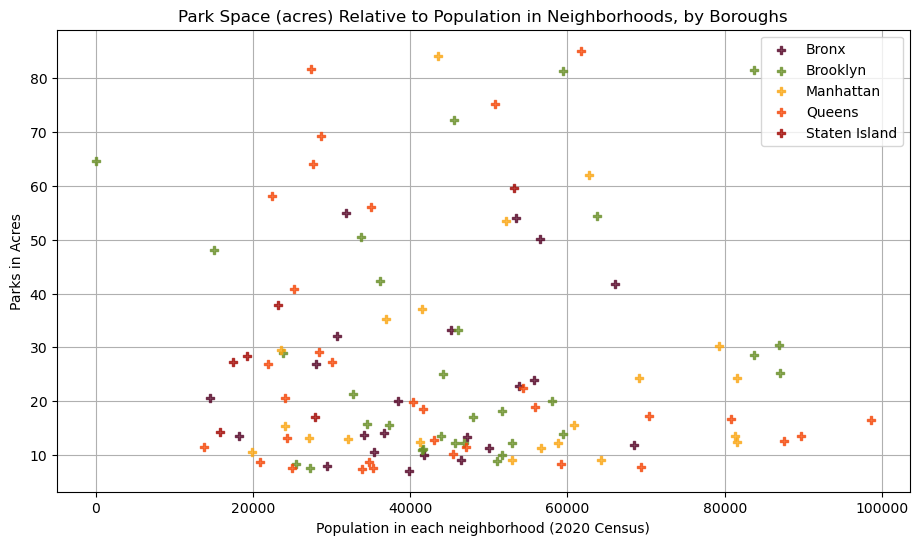

In [25]:

color_map = {"Bronx": "#550527", "Brooklyn": "#688E26", "Manhattan": "#FAA613", "Queens": "#F44708", "Staten Island": "#A10702"}

fig, ax = plt.subplots(figsize=(11,6))

for BoroName, group_df in parks_pop_filtered.groupby("BoroName"):
    
    ax.scatter(
        group_df["estimate"],
        group_df["acres"],
        marker="P",
        label=BoroName,
        color=color_map[BoroName],
        alpha=0.75,
        zorder=10
    )

ax.legend(loc="best")
ax.set(
    title = "Park Space (acres) Relative to Population in Neighborhoods, by Boroughs",
    xlabel = "Population in each neighborhood (2020 Census)",
    ylabel = "Parks in Acres")
ax.grid(True)

plt.show()

This chart does not suggest a strong linear relationship between population and park acrages. Overall, Manhattan, Queens and Brooklyn host more large parks, but some neighborhoods are particularly underserved, with very high population and low park acrage (points towards lower right of the chart). 

## Chart II: Seaborn (x2)

Looking at data for indoor leisure space and open street data, I utilize seaborn to create two types of charts that suite the nature of the data sets. 

The first is a grouped bar charts. Similar to park distribution, I hope to have a quick glimpse of number of each type of leisure spaces in each borough, and hope to identify any general spatial patterns or inequalities. A grouped chart is great a revealing such pattern.

The second is a heatmap for open street data. The heatmap explores the number of open streets approved in different boroughs on different days of the week. 



### Indoor Leisure Spaces: Grouped Bar Charts

In [26]:
indoor_clean = geo_total_indoor.groupby(['Type','BoroName']).count().reset_index().drop(columns=['Zip','Address','geometry','index_right','CT2020','NTAName']).pivot(index='Type',columns='BoroName', values='Name').fillna(0).reset_index()
indoor_melt = indoor_clean.melt(id_vars='Type', value_vars=['Bronx','Brooklyn','Manhattan', 'Queens', 'Staten Island'])
indoor_melt

Type       BoroName  value
0   Art Galleries          Bronx    6.0
1       Libraries          Bronx   35.0
2         Museums          Bronx    8.0
3        Theatres          Bronx    0.0
4   Art Galleries       Brooklyn   61.0
5       Libraries       Brooklyn   59.0
6         Museums       Brooklyn   12.0
7        Theatres       Brooklyn    0.0
8   Art Galleries      Manhattan  823.0
9       Libraries      Manhattan   44.0
10        Museums      Manhattan   87.0
11       Theatres      Manhattan  115.0
12  Art Galleries         Queens   24.0
13      Libraries         Queens   65.0
14        Museums         Queens   12.0
15       Theatres         Queens    2.0
16  Art Galleries  Staten Island    3.0
17      Libraries  Staten Island   13.0
18        Museums  Staten Island    9.0
19       Theatres  Staten Island    0.0

/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


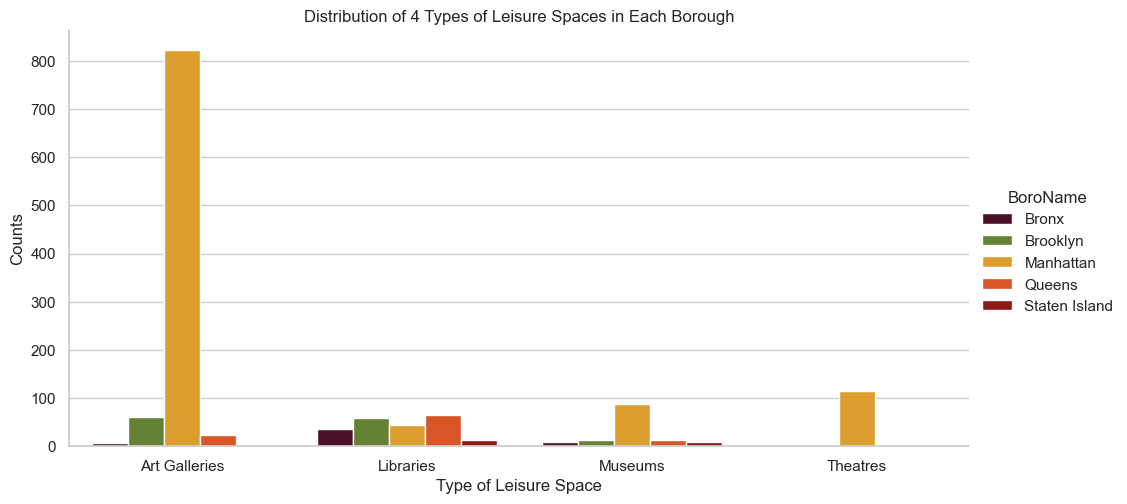

In [27]:
sns.set_theme(style="whitegrid")

color_map = ["#550527", "#688E26", "#FAA613", "#F44708", "#A10702"]
sns.set_palette(color_map)

sns.catplot(
    data=indoor_melt, kind="bar",
    x="Type", 
    y="value", 
    hue="BoroName",
    aspect=2, 
    alpha=1
).set_axis_labels(
    "Type of Leisure Space", "Counts"
).set(title="Distribution of 4 Types of Leisure Spaces in Each Borough")

### Days and Location of Open Streets in NYC: A Heatmap

In [43]:
#heatmap for open_streets: borough x Days of the week 
open_streets_days_melt= open_streets_days.melt(id_vars=['appronstre','BoroName'], value_vars=['monday','tuesday','wednesday', 'thursday', 'friday','saturday','sunday'])

appronstre       BoroName variable  value
0     DEISIUS STREET  Staten Island   monday      1
1     SUFFOLK AVENUE  Staten Island   monday      0
2     SUFFOLK AVENUE  Staten Island   monday      0
3      VERMONT COURT  Staten Island   monday      0
4           9 STREET  Staten Island   monday      0
...              ...            ...      ...    ...
2557     BECK STREET          Bronx   sunday      0
2558  NEWKIRK AVENUE       Brooklyn   sunday      1
2559       18 STREET       Brooklyn   sunday      0
2560       34 AVENUE         Queens   sunday      1
2561  DECATUR STREET       Brooklyn   sunday      0

[2562 rows x 4 columns]

In [44]:
open_streets_seaborn = open_streets_days_melt.groupby(['variable','BoroName']).sum().reset_index()

# sort the order of day from monday to sunday 

order=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
open_streets_seaborn['variable'] = pd.Categorical(open_streets_seaborn['variable'], categories=order, ordered=True)
open_streets_seaborn = open_streets_seaborn.sort_values(by='variable')


/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/3045256453.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  open_streets_seaborn = open_streets_days_melt.groupby(['variable','BoroName']).sum().reset_index()


[Text(0.5, 33.249999999999986, 'Days in a week'),
 Text(79.75, 0.5, 'Borough'),
 Text(0.5, 1.0, 'Number of Streets Open on Specific Days')]

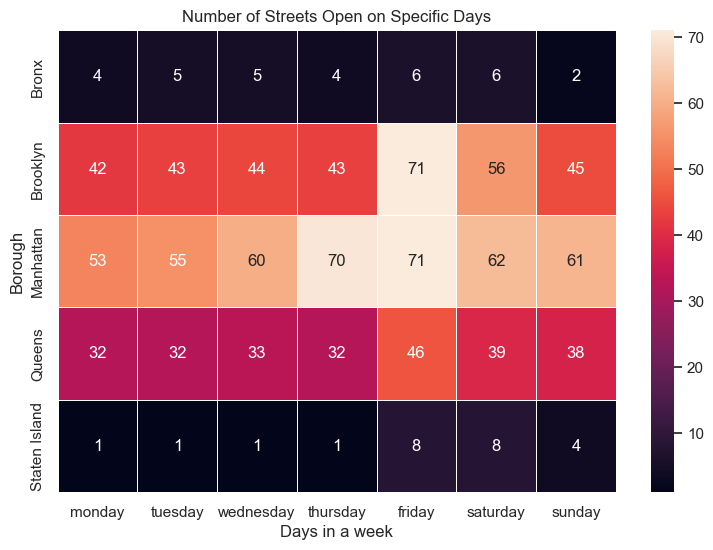

In [45]:
import seaborn as sns

sns.set_theme()

# Load the example flights dataset and convert to long-form

open_street_heatmap = (
    open_streets_seaborn
    .pivot(index="BoroName", columns="variable", values="value")
)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))

ax = sns.heatmap(open_street_heatmap, annot=True, linewidths=.5)
ax.set(xlabel="Days in a week", ylabel="Borough", title="Number of Streets Open on Specific Days")



From both charts, we can see Manhattan has disproportional number of art galleries and open streets in comparison to other boroughs. Museums and theatres are predominantly located on Manhattan as well. Interestingly, the distribution of libraries seems more even. However, overall, we are seeing leisure spaces are disproportional abundant and diverse in Manhattan, then brooklyn and queens, leaving Bronx and Staten Island less resourceful.

## Chart III: Altair Charts (x3) 

Furthering the exploration on indoor leisure spaces, I created one chart on its ditribution in relation with median household income, to see if it embeds any socio-economic inequality. I then creatd a map to visualize this relationship, which can also be helpful to locate different kinds of leisure spaces in the city. 

My third chart is an interactive bar chart on open streets in Brookylen, where audience can choose the day of the week to see all open streets approved for that day and the time they open and close. This could potentially be developed into a tool for residents and tourists to track open streets. 

### Brush Selection: Indoor Space and Income

In [47]:
neighbor_indoor = geo_total_indoor.groupby(['NTAName','Type']).count().reset_index().drop(['Zip', 'Address', 'geometry','index_right','BoroName', 'CT2020'], axis=1)
neighbor_indoor = neighbor_indoor.rename(columns={'Name': 'Count'})
neighbor_income_indoor = neighbor_income.merge(neighbor_indoor, on='NTAName', how='left')

neighbor_income_indoor_pivot=neighbor_income_indoor.pivot(index=['NTAName', 'BoroName','estimate'], columns="Type", values="Count").reset_index().fillna(0)
neighbor_income_indoor_pivot_1 = neighbor_income_indoor_pivot.drop(neighbor_income_indoor_pivot.columns[[3]],axis=1)
income_indoor_pivot = neighbor_income_indoor_pivot_1.melt(id_vars=["NTAName", "estimate", "BoroName"], value_vars=["Art Galleries", "Libraries", "Museums", "Theatres"], var_name="Types",value_name="Count")
income_indoor_pivot_filtered = income_indoor_pivot.loc[(income_indoor_pivot['Count'] <20)]
income_indoor_pivot_filtered = income_indoor_pivot_filtered.rename(columns={'estimate': 'Median Household Income'})


In [48]:
brush = alt.selection_interval()

Brush_Chart = (
alt.Chart(income_indoor_pivot_filtered)
   .mark_point()
   .encode(
       x=alt.X("Median Household Income:Q", scale=alt.Scale(zero=False)),
       y=alt.Y("Count:Q", scale=alt.Scale(zero=False)),
       color=alt.condition(brush, "BoroName:N", alt.value("lightgray")),
       tooltip=["NTAName","BoroName:N", "Median Household Income:Q", "Count:Q"])
   .add_params(brush)
   .properties(width=200, height=200)
   .facet(column="Types:N")
)

Brush_Chart

alt.FacetChart(...)

### Map: Income and Indoor Leisure Spaces - Relationships

In [52]:
NTA = pd.read_csv("data/2020 Neighborhood.csv")
NTA['geometry'] = gpd.GeoSeries.from_wkt(NTA['the_geom'])
NTA_geo = gpd.GeoDataFrame(NTA, geometry='geometry', crs=4326)
NTA_geo = NTA_geo.to_crs(epsg=2263)
geo_total_indoor = geo_total_indoor.to_crs(epsg=2263)

geo_NTA = NTA_geo[['NTAName', 'geometry']]

tracts_income_1 = tracts_clean.merge(geo_income.drop(columns='geometry'), on='GEOID', how='left').dropna()
neighbor_income_1 = tracts_income.groupby(['NTAName', 'BoroName']).median(['estimate']).reset_index()

NTA_income = geo_NTA.merge(neighbor_income_1, on='NTAName', how='left')

In [53]:
geo_total_indoor_1 = geo_total_indoor

geo_total_indoor_1['lon'] = geo_total_indoor_1['geometry'].x
geo_total_indoor_1['lat'] = geo_total_indoor_1['geometry'].y


In [55]:
Income = (
    alt.Chart(NTA_income)
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["NTAName:N", "estimate:Q", "moe:Q"],
        color=alt.Color("estimate:Q", scale=alt.Scale(scheme="greys")),
    )
    # Important! Otherwise altair will try to re-project your data
    .project(type="identity", reflectY=True)
    .properties(width=1000, height=800).interactive()
)

IndoorSpaces = (
    alt.Chart(geo_total_indoor_1)
    .mark_circle(size=10)
    .encode(tooltip=['Name','Type','Address'],
           longitude="lon", latitude="lat",
           color=alt.Color('Type:N', scale=alt.Scale(scheme="lightmulti"))
         ).project(type="identity", reflectY=True)
)



map_1 = Income + IndoorSpaces
map_1

alt.LayerChart(...)

Similarly, libraries seem to be the least discriminatory type of leisure space. For art galleries and museums, while there are some distributed in mid to lower income neighborhood, the higher income neighborhood has higher density of such leisure space. Theatres, at the same time, is mostly located in mid to higher income neighborhood. This trend can be clearly see on the map too. Such spatial distribution means, for residents in lower to mid income neighborhood, they might have to travel further for accessing those spaces. 

### Open Street Time

In [76]:
open_csv = pd.read_csv("data/Open Streets CSV.csv")
open_csv['geometry'] = gpd.GeoSeries.from_wkt(open_csv['the Geom'])
open_csv_geo = gpd.GeoDataFrame(open_csv, geometry='geometry', crs=2263)
open_csv_geo = open_csv_geo.to_crs(epsg=4326)

open_7days_time = open_csv_geo.drop(['apprDaysWe','Object ID', 'Organization Name', 'Approved From Street', 'Approved To Street', 'apprStartD', 'apprEndDat', 'Shape_STLe', 'segmentidt', 'segmentidf', 'lionversion', 'the Geom'], axis=1)
open_7days_time = open_7days_time.drop_duplicates(subset = "Approved On Street")
open_7days_time_melt = open_7days_time.melt(id_vars=['Approved On Street', 'Borough Name'], value_vars=['Approved Monday Open', 'Approved Monday Close', 'Approved Tuesday Open', 'Approved Tuesday Close', 'Approved Wednesday Open', 'Approved Wednesday Close', 'Approved Thursday Open', 'Approved Thursday Close', 'Approved Friday Open', 'Approved Friday Close', 'Approved Saturday Open', 'Approved Saturday Close', 'Approved Sunday Open', 'Approved Sunday Close']).dropna()
#open_7days_time_melt['value'] =  pd.to_datetime(open_7days_time_melt['value']).dt.time
open_time_Brooklyn = open_7days_time_melt[(open_7days_time_melt['Borough Name'] == 'Brooklyn')]
open_time_Brooklyn

Approved On Street Borough Name               variable  value
6       RIDGE BOULEVARD     Brooklyn   Approved Monday Open  10:00
9             82 STREET     Brooklyn   Approved Monday Open  08:30
10            48 STREET     Brooklyn   Approved Monday Open  13:30
11            43 STREET     Brooklyn   Approved Monday Open  09:30
12       ALBEMARLE ROAD     Brooklyn   Approved Monday Open  08:00
...                 ...          ...                    ...    ...
2282   JEFFERSON AVENUE     Brooklyn  Approved Sunday Close  21:00
2287      SHARON STREET     Brooklyn  Approved Sunday Close  20:00
2288    TROUTMAN STREET     Brooklyn  Approved Sunday Close  22:00
2289    RANDOLPH STREET     Brooklyn  Approved Sunday Close  23:00
2354   LEXINGTON AVENUE     Brooklyn  Approved Sunday Close  20:00

[378 rows x 4 columns]

In [77]:
open_time_Brooklyn['time'] = open_7days_time_melt['variable'].str.extract('(Open|Close)')
open_time_Brooklyn['dayweek'] = open_7days_time_melt['variable'].str.extract('(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)')
open_time_Brooklyn= open_time_Brooklyn.pivot(index=['Approved On Street', 'dayweek'], columns="time", values="value").reset_index()

order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
open_time_Brooklyn['dayweek'] = pd.Categorical(open_time_Brooklyn['dayweek'], categories=order, ordered=True)
open_time_Brooklyn = open_time_Brooklyn.sort_values(by='dayweek').reset_index()

open_time_Brooklyn


/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/1900940832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_time_Brooklyn['time'] = open_7days_time_melt['variable'].str.extract('(Open|Close)')
/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_80527/1900940832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_time_Brooklyn['dayweek'] = open_7days_time_melt['variable'].str.extract('(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)')


time  index Approved On Street dayweek  Close   Open
0       139      SUMMIT STREET  Monday  14:30  12:30
1       151   UNDERHILL AVENUE  Monday  20:00  08:00
2        28          82 STREET  Monday  15:30  08:30
3       143    THATFORD AVENUE  Monday  18:00  11:00
4        33       AITKEN PLACE  Monday  15:00  11:00
..      ...                ...     ...    ...    ...
184     147    TOMPKINS AVENUE  Sunday  20:00  11:00
185      51      BEVERLEY ROAD  Sunday  18:00  10:00
186     112    RANDOLPH STREET  Sunday  23:00  12:00
187      10           4 STREET  Sunday  22:00  08:00
188     157  VANDERBILT AVENUE  Sunday  23:00  11:00

[189 rows x 5 columns]

In [79]:
selection = alt.selection_multi(fields=['dayweek'])
color = alt.condition(selection,
                      alt.Color('dayweek:N', legend=None, 
                      scale=alt.Scale(scheme='category10')),
                      alt.value('lightgray'))

opacity = alt.condition(selection,
                        alt.value(1), alt.value(0))



bar = alt.Chart(open_time_Brooklyn).mark_bar().encode(
        x='Open',
        x2='Close',
        y='Approved On Street',
        color=color,
        opacity=opacity,
        tooltip=['Open', 'Close', 'Approved On Street', 'dayweek']).properties(
        width=500,
        height=1000).interactive()

legend = alt.Chart(open_time_Brooklyn).mark_bar().encode(
    y=alt.Y('dayweek:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
selection
)

A_Chart = bar | legend
A_Chart



alt.HConcatChart(...)

This interactive bar chart on Brooklyn Open Street serves as a pilot that can be adapted for data of all five boroughs. By comparing to open and close time, we can observe that many streets are approved to be open streets with later opening and closing time on weekends. To improve this bar chart the status of each street can be added (i.e., whether they are approved to be closed fully or partially or only on school days), which is important for visitors as well. 

## Dashboard

The dashboard below is an upgrade from the indoor space and income grouped scatter plot. This dashboard makes it easier to explore the spatial distribution of indoor spaces of certain type or in neighborhoods with certain level of income. Through selecting points with higher counts, we can see neighborhoods with higher density of identified indoor leisure spaces are mostly located in Manhattan. 

In [56]:
brush = alt.selection_interval()

points = alt.Chart(income_indoor_pivot_filtered).mark_point().encode(
       x=alt.X("Median Household Income:Q", scale=alt.Scale(zero=False)),
       y=alt.Y("Count:Q", scale=alt.Scale(zero=False)),
       color=alt.condition(brush, "BoroName:N", alt.value("lightgray")),
       tooltip=["NTAName","BoroName:N", "Median Household Income:Q", "Count:Q"]).add_params(brush
).properties(width=200, height=200
).facet(column="Types:N")


bars = alt.Chart(income_indoor_pivot_filtered).mark_bar().encode(
    y='BoroName:N',
    color='BoroName:N',
    x='Count:Q'
).transform_filter(
    brush
)

Dashboard = points & bars
Dashboard

alt.VConcatChart(...)